In [1]:
import pandas as pd
import numpy as np
import json
import folium
from datetime import datetime, timedelta
import os
import seaborn as sns
import matplotlib as plt

import yaml

In [2]:
from data_cleaning.json_manipulation import load_json, trim_json_to_locations, gather_bajs_locations, get_bikes_in_stations, calculate_bike_changes, create_changes_columns
from visualization.station_map import populate_map_with_stations
from visualization.individual_station_plots import plot_hourly_bar, plot_weekday_bar, stringify_plot, combined_plot_daily_weekly
from data_cleaning.data_wrangling import create_hourly_df, create_weekday_df

In [3]:
config = yaml.safe_load(open("../config.YAML"))

In [4]:
with open("../data/test_JSON_data/bajs_10-11-2025_15-11-31.json") as json_data:
    day_one = json.load(json_data)
    json_data.close()

In [5]:
day_one

{'countries': [{'lat': 45.8049,
   'lng': 15.9467,
   'zoom': 10,
   'name': 'Bajs Zagreb (Croatia)',
   'hotline': '0038515494477',
   'domain': 'hd',
   'language': 'hr',
   'email': 'bajs@zagreb.hr',
   'timezone': 'Europe/Berlin',
   'currency': 'EUR',
   'country_calling_code': '+385',
   'system_operator_address': 'Sustav javnih bicikala d.o.o., Prisavlje 2, 10000 Zagreb',
   'country': 'HR',
   'country_name': 'Croatia',
   'terms': 'https://bajs.zagreb.hr/hr/uvjetikoristenja/',
   'policy': 'https://bajs.zagreb.hr/hr/pravila-privatnosti/',
   'website': 'https://bajs.zagreb.hr',
   'show_bike_types': False,
   'show_bike_type_groups': False,
   'show_free_racks': False,
   'booked_bikes': 0,
   'set_point_bikes': 2000,
   'available_bikes': 1812,
   'capped_available_bikes': False,
   'no_registration': False,
   'pricing': 'https://bajs.zagreb.hr/hr/',
   'vat': '25',
   'faq_url': 'https://bajs.zagreb.hr',
   'store_uri_android': 'https://play.google.com/store/apps/details?id

In [6]:
trim_json_to_locations(day_one)

[{'uid': 556632908,
  'lat': 45.825299,
  'lng': 16.109747,
  'bike': False,
  'name': 'AUTOBUSNI TERMINAL SESVETE',
  'address': None,
  'spot': True,
  'number': 21200,
  'booked_bikes': 0,
  'bikes': 5,
  'bikes_available_to_rent': 5,
  'active_place': 1,
  'bike_racks': 8,
  'free_racks': 3,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800463', '800020', '801638', '801088', '801072'],
  'bike_types': {'196': 4, '409': 1},
  'place_type': '0',
  'rack_locks': False},
 {'uid': 556633495,
  'lat': 45.842797,
  'lng': 15.975421,
  'bike': False,
  'name': 'MIHALJEVAC OKRETIŠTE',
  'address': None,
  'spot': True,
  'number': 21201,
  'booked_bikes': 0,
  'bikes': 11,
  'bikes_available_to_rent': 11,
  'active_place': 1,
  'bike_racks': 12,
  'free_racks': 1,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800480',
   '800247',
   '800185',
 

In [7]:
locations = gather_bajs_locations(trim_json_to_locations(day_one))
locations.head()

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20


In [8]:
locations.shape
# 165 different stations in Zagreb

(165, 5)

Thunderforest.Neighbourhood
OSMBright
Esri.WorldTopoMap
CartoDB.Voyager

In [9]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [10]:
circles = populate_map_with_stations(m, locations)
_ = [circ.add_to(m) for circ in circles]


In [11]:
m

## Individual bikes at individual times

In [12]:
first_dt = datetime.strptime("2025/11/10 15:11:31",
    "%Y/%m/%d %H:%M:%S")

first_dt

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [13]:
time1 = get_bikes_in_stations(time = first_dt,
    loc_list = trim_json_to_locations(day_one))

time1.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."


In [14]:
# For testing purposes, we'll use this data as a second timepoint even though it's been more than a day
with open("../data/test_JSON_data/bajs_12-11-2025_09-30-11.json") as json_data:
    day_two = json.load(json_data)
    json_data.close()

In [15]:
second_dt = datetime.strptime("2025/11/10 16:30:00",
    "%Y/%m/%d %H:%M:%S")

time2 = get_bikes_in_stations(time = second_dt,
    loc_list = trim_json_to_locations(day_two))

time2.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:30:00,"[800479, 800463, 800282, 801088]"
1,556633495,2025-11-10 16:30:00,"[800480, 800185, 800052, 801489, 801321]"
2,556634009,2025-11-10 16:30:00,"[800274, 801882, 801360, 801296, 801022]"
3,556637365,2025-11-10 16:30:00,"[800344, 800033, 801920, 801915, 801881, 80164..."
4,556689563,2025-11-10 16:30:00,"[800485, 800329, 800233, 800230, 800223, 80019..."


In [16]:
more_times = pd.concat([time1, time2])
# for each uid-time, what is the closest observed time before the one in this row?
more_times["lag1_time"] = more_times.groupby(["uid"])["time"].shift(1)

more_times

previous_bikes = more_times.merge(more_times.drop(["lag1_time"], axis = 1), # so we don't get this as an additional column
    how = "left",
    left_on = ["uid", "lag1_time"],
    right_on = ["uid", "time"],
    suffixes = (None, "_lag1")).drop(
        ["time_lag1"], axis = 1
    )



previous_bikes

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN
...,...,...,...,...,...
326,585913527,2025-11-10 16:30:00,"[800278, 800101, 801656, 801228, 801046, 80077...",2025-11-10 15:11:31,[]
327,585913605,2025-11-10 16:30:00,"[801717, 801191, 801157, 800603, 800601, 800517]",2025-11-10 15:11:31,[801963]
328,585913702,2025-11-10 16:30:00,"[800347, 800115, 801866, 801826, 801795, 80166...",2025-11-10 15:11:31,"[800293, 800219, 800191, 800068, 801907, 80175..."
329,586256300,2025-11-10 16:30:00,"[800144, 801889, 801867, 801457, 801066, 80095...",2025-11-10 15:11:31,"[800318, 800144, 801889, 801867, 801169, 80116..."


In [17]:
calculate_bike_changes(previous_bikes["bikes_at_station"], previous_bikes["bikes_at_station_lag1"])

{'changes': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     7.0
 328    31.0
 329     5.0
 330     5.0
 Length: 331, dtype: float64,
 'incoming': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     0.0
 327     1.0
 328    15.0
 329     3.0
 330     0.0
 Length: 331, dtype: float64,
 'outgoing': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     6.0
 328    16.0
 329     2.0
 330     5.0
 Length: 331, dtype: float64}

## Load all data from folder and calculate changes

In [18]:
raw_files_directory = "../data/" + config["data"]["raw_json_folder"]

raw_files = os.listdir(raw_files_directory)
raw_files

['bajs_10-11-2025_17-04-53.json',
 'bajs_10-11-2025_18-24-00.json',
 'bajs_10-11-2025_19-21-13.json',
 'bajs_10-11-2025_20-15-53.json',
 'bajs_10-11-2025_21-02-43.json',
 'bajs_10-11-2025_22-14-02.json',
 'bajs_10-11-2025_23-01-43.json',
 'bajs_11-11-2025_00-15-08.json',
 'bajs_11-11-2025_01-13-15.json',
 'bajs_11-11-2025_02-05-07.json',
 'bajs_11-11-2025_03-17-33.json',
 'bajs_11-11-2025_04-00-29.json',
 'bajs_11-11-2025_05-04-41.json',
 'bajs_11-11-2025_06-27-27.json',
 'bajs_11-11-2025_07-19-42.json',
 'bajs_11-11-2025_08-17-33.json',
 'bajs_11-11-2025_09-06-29.json',
 'bajs_11-11-2025_10-13-20.json',
 'bajs_11-11-2025_11-06-31.json',
 'bajs_11-11-2025_12-24-02.json',
 'bajs_11-11-2025_13-00-30.json',
 'bajs_11-11-2025_14-08-36.json',
 'bajs_11-11-2025_15-00-39.json',
 'bajs_11-11-2025_16-29-45.json',
 'bajs_11-11-2025_17-04-53.json',
 'bajs_11-11-2025_18-05-53.json',
 'bajs_11-11-2025_19-03-15.json',
 'bajs_11-11-2025_20-05-27.json',
 'bajs_11-11-2025_21-09-35.json',
 'bajs_11-11-2

In [19]:
raw_files[0][5:-5]

'10-11-2025_17-04-53'

In [20]:
#TODO - extracting from first to last number instead of absolute position?

datetime.strptime(raw_files[0][5:-5], "%d-%m-%Y_%H-%M-%S")

datetime.datetime(2025, 11, 10, 17, 4, 53)

In [21]:
scraped_datetimes = [datetime.strptime(filename[5:-5], "%d-%m-%Y_%H-%M-%S") for filename in raw_files]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 17, 4, 53),
 datetime.datetime(2025, 11, 10, 18, 24),
 datetime.datetime(2025, 11, 10, 19, 21, 13),
 datetime.datetime(2025, 11, 10, 20, 15, 53),
 datetime.datetime(2025, 11, 10, 21, 2, 43),
 datetime.datetime(2025, 11, 10, 22, 14, 2),
 datetime.datetime(2025, 11, 10, 23, 1, 43),
 datetime.datetime(2025, 11, 11, 0, 15, 8),
 datetime.datetime(2025, 11, 11, 1, 13, 15),
 datetime.datetime(2025, 11, 11, 2, 5, 7),
 datetime.datetime(2025, 11, 11, 3, 17, 33),
 datetime.datetime(2025, 11, 11, 4, 0, 29),
 datetime.datetime(2025, 11, 11, 5, 4, 41),
 datetime.datetime(2025, 11, 11, 6, 27, 27),
 datetime.datetime(2025, 11, 11, 7, 19, 42),
 datetime.datetime(2025, 11, 11, 8, 17, 33),
 datetime.datetime(2025, 11, 11, 9, 6, 29),
 datetime.datetime(2025, 11, 11, 10, 13, 20),
 datetime.datetime(2025, 11, 11, 11, 6, 31),
 datetime.datetime(2025, 11, 11, 12, 24, 2),
 datetime.datetime(2025, 11, 11, 13, 0, 30),
 datetime.datetime(2025, 11, 11, 14, 8, 36),
 datetime.dateti

**IMPORTANT**  
The scraper times need to be adjusted up by an hour to match the local times!

In [22]:
scraped_datetimes = [date + timedelta(hours = 1) for date in scraped_datetimes]
scraped_datetimes

[datetime.datetime(2025, 11, 10, 18, 4, 53),
 datetime.datetime(2025, 11, 10, 19, 24),
 datetime.datetime(2025, 11, 10, 20, 21, 13),
 datetime.datetime(2025, 11, 10, 21, 15, 53),
 datetime.datetime(2025, 11, 10, 22, 2, 43),
 datetime.datetime(2025, 11, 10, 23, 14, 2),
 datetime.datetime(2025, 11, 11, 0, 1, 43),
 datetime.datetime(2025, 11, 11, 1, 15, 8),
 datetime.datetime(2025, 11, 11, 2, 13, 15),
 datetime.datetime(2025, 11, 11, 3, 5, 7),
 datetime.datetime(2025, 11, 11, 4, 17, 33),
 datetime.datetime(2025, 11, 11, 5, 0, 29),
 datetime.datetime(2025, 11, 11, 6, 4, 41),
 datetime.datetime(2025, 11, 11, 7, 27, 27),
 datetime.datetime(2025, 11, 11, 8, 19, 42),
 datetime.datetime(2025, 11, 11, 9, 17, 33),
 datetime.datetime(2025, 11, 11, 10, 6, 29),
 datetime.datetime(2025, 11, 11, 11, 13, 20),
 datetime.datetime(2025, 11, 11, 12, 6, 31),
 datetime.datetime(2025, 11, 11, 13, 24, 2),
 datetime.datetime(2025, 11, 11, 14, 0, 30),
 datetime.datetime(2025, 11, 11, 15, 8, 36),
 datetime.dateti

In [23]:
data_timepoints = [
    trim_json_to_locations(load_json(raw_files_directory + "/" + json_file))
    for json_file
    in raw_files
]

len(data_timepoints)

165

In [24]:
bike_data = None

for i in range(len(data_timepoints)):
    timepoint_bikes = get_bikes_in_stations(time = scraped_datetimes[i],
        loc_list = data_timepoints[i])

    if i == 0: 
        bike_data = timepoint_bikes
    else:
        bike_data = pd.concat([bike_data, timepoint_bikes])

bike_data

,uid,time,bikes_at_station
0,556632908,2025-11-10 18:04:53,"[800463, 800020, 801638, 801088, 800874]"
1,556633495,2025-11-10 18:04:53,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 18:04:53,"[800220, 800201, 800129, 800079, 801882, 80164..."
3,556637365,2025-11-10 18:04:53,"[800345, 800193, 801920, 801915, 801881, 80164..."
4,556689563,2025-11-10 18:04:53,"[801846, 801548, 801347, 801000, 800817, 80062..."
...,...,...,...
164,585913605,2025-11-17 14:12:59,"[800370, 801928, 801096, 800874]"
165,585913702,2025-11-17 14:12:59,"[800491, 800360, 800122, 801734, 801644, 80128..."
166,586256300,2025-11-17 14:12:59,"[800315, 800183, 800144, 801889, 801558, 80124..."
167,586273004,2025-11-17 14:12:59,"[800457, 800367, 801935, 801924, 801917, 80185..."


In [25]:
bike_data = create_changes_columns(bike_data)
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
0,556632908,2025-11-10 18:04:53,"[800463, 800020, 801638, 801088, 800874]",NaT,NaN,NaN,NaN,NaN
1,556633495,2025-11-10 18:04:53,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN,NaN,NaN,NaN
2,556634009,2025-11-10 18:04:53,"[800220, 800201, 800129, 800079, 801882, 80164...",NaT,NaN,NaN,NaN,NaN
3,556637365,2025-11-10 18:04:53,"[800345, 800193, 801920, 801915, 801881, 80164...",NaT,NaN,NaN,NaN,NaN
4,556689563,2025-11-10 18:04:53,"[801846, 801548, 801347, 801000, 800817, 80062...",NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27566,585913605,2025-11-17 14:12:59,"[800370, 801928, 801096, 800874]",2025-11-17 13:06:22,"[800370, 801928, 801486, 801096, 800874]",1.0,0.0,1.0
27567,585913702,2025-11-17 14:12:59,"[800491, 800360, 800122, 801734, 801644, 80128...",2025-11-17 13:06:22,"[800491, 800360, 800122, 801734, 801644, 80128...",0.0,0.0,0.0
27568,586256300,2025-11-17 14:12:59,"[800315, 800183, 800144, 801889, 801558, 80124...",2025-11-17 13:06:22,"[800183, 800144, 801889, 801558, 801244, 80118...",1.0,1.0,0.0
27569,586273004,2025-11-17 14:12:59,"[800457, 800367, 801935, 801924, 801917, 80185...",2025-11-17 13:06:22,"[800457, 800367, 801950, 801935, 801924, 80191...",3.0,1.0,2.0


## Total changes on map

In [26]:
# For each station, sum up all changes through time
# Also, weight changes by rack size

total_changes = bike_data.groupby("uid").sum(["changes"])
total_changes = total_changes.rename({"changes":"total_changes"}, axis = 1)
total_changes

,total_changes,incoming,outgoing
uid,,,
556632908,40.0,22.0,18.0
556633495,64.0,30.0,34.0
556634009,304.0,147.0,157.0
556637365,261.0,132.0,129.0
556689563,824.0,414.0,410.0
...,...,...,...
585913605,128.0,65.0,63.0
585913702,150.0,78.0,72.0
586256300,38.0,20.0,18.0


In [27]:
locations_changes = locations.join(total_changes, on = "uid")
locations_changes["weighted_changes"] = locations_changes["total_changes"] / locations_changes["no_racks"]
locations_changes

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,40.0,22.0,18.0,5.000000
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,64.0,30.0,34.0,5.333333
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,304.0,147.0,157.0,30.400000
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,261.0,132.0,129.0,13.050000
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,824.0,414.0,410.0,41.200000
...,...,...,...,...,...,...,...,...,...
160,585913527,GUPČEVA ZVIJEZDA,45.827987,15.979160,10,126.0,71.0,55.0,12.600000
161,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,128.0,65.0,63.0,12.800000
162,585913702,KORANSKA UL.,45.802365,15.968013,10,150.0,78.0,72.0,15.000000
163,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,38.0,20.0,18.0,3.800000


In [28]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [29]:
circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Bike changes: ",
                               no_bins = 12)
_ = [circ.add_to(m) for circ in circles]

In [30]:
m

We can see that the number of racks DOESN'T necessarily mean that this is the maximum amount of bikes that can be at a station at the same time. Maybe they're counted if they're in the near vicinity?  

Still, the no_racks is still useful as an approximation of how large/frequently used the station is planned to be.

### Tables of usage
Most and least used total

In [31]:
locations_changes.sort_values("total_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
26,556723550,TRG KRALJA TOMISLAVA,45.805057,15.978300,57,1108.0,534.0,574.0,19.438596
18,556702069,S.D. CVJETNO NASELJE,45.790564,15.961748,30,954.0,472.0,482.0,31.800000
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,824.0,414.0,410.0,41.200000
12,556696500,S.D. STJEPAN RADIĆ,45.784832,15.949303,20,686.0,348.0,338.0,34.300000
58,579364165,FILOZOFSKI FAKULTET,45.796235,15.970371,20,656.0,324.0,332.0,32.800000


In [32]:
locations_changes.sort_values("total_changes",  ascending = True).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
117,583385565,SD SUTINSKA VRELA,45.817745,15.832586,8,3.0,3.0,0.0,0.375
131,583391639,CARINARNICA ZAGREB,45.800518,16.057125,8,4.0,0.0,4.0,0.500
155,585911812,RADNIČKA CESTA 228,45.778281,16.054742,10,7.0,5.0,2.0,0.700
154,585911645,ŽIČARA SLJEME,45.860911,15.982901,10,11.0,4.0,7.0,1.100
50,579361783,AUTOBUSNO STAJALIŠTE PRIGORNICA,45.815251,15.848368,10,12.0,8.0,4.0,1.200


Most used relative to number of racks provided - possibly could use more racks installed:

In [33]:
locations_changes.sort_values("weighted_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
87,579368895,PARK KATE ŠOLJIĆ,45.803227,15.942999,7,357.0,181.0,176.0,51.0
119,583385717,SELSKA CESTA - UL. BLAŽA TROGIRANINA,45.791090,15.944574,10,437.0,216.0,221.0,43.7
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,824.0,414.0,410.0,41.2
15,556698504,REMIZA LJUBLJANICA,45.797350,15.938160,10,396.0,200.0,196.0,39.6
41,573743895,PRERADOVIĆEVA UL.,45.811080,15.974207,10,395.0,191.0,204.0,39.5


## Usage by time of day

In [34]:
hourly = create_hourly_df(bike_data)
hourly.head()

changes  incoming  outgoing
uid       hour                             
556632908 0         0.0       0.0       0.0
          1         0.0       0.0       0.0
          2         0.0       0.0       0.0
          3         0.0       0.0       0.0
          4         0.0       0.0       0.0

In [35]:
# plots for one station

# trg kralja tomislava
station = 556723550

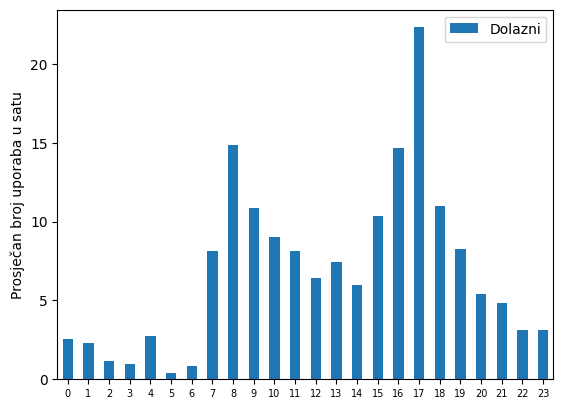

In [36]:
_ = plot_hourly_bar(hourly.loc[station], changes_type = "total")

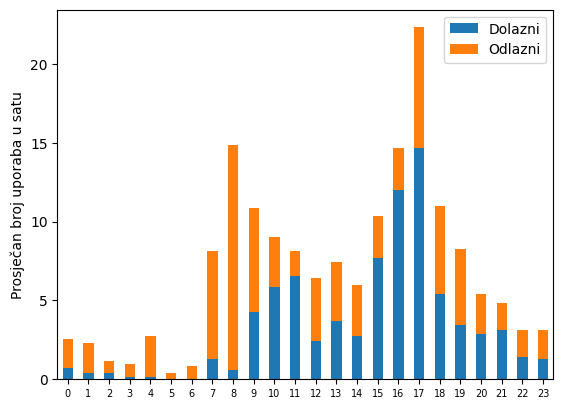

In [37]:
_ = plot_hourly_bar(hourly.loc[station], changes_type = "in/out")

## Usage by day of week

In [38]:
daily = create_weekday_df(bike_data)
daily.head()

changes  incoming  outgoing
uid       wday                             
556632908 0         1.5       1.0       0.5
          1         5.0       3.0       2.0
          2         8.0       4.0       4.0
          3         7.0       3.0       4.0
          4         8.0       6.0       2.0

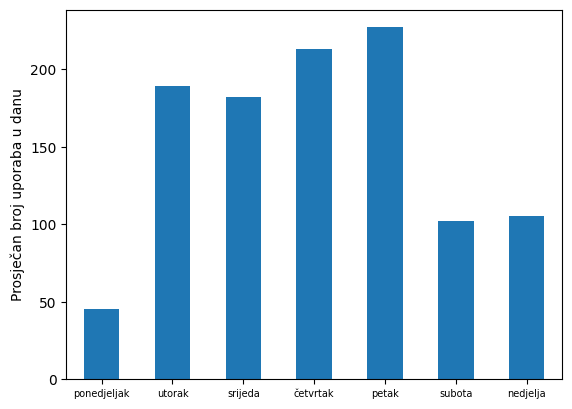

In [39]:
daily_plot = plot_weekday_bar(daily.loc[station])

'\n    \n    '
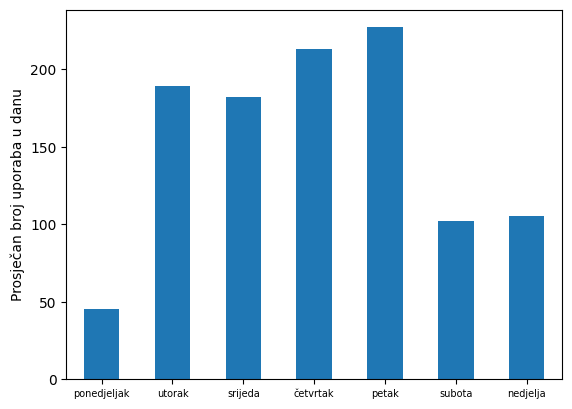

In [40]:
stringify_plot(daily_plot.get_figure())

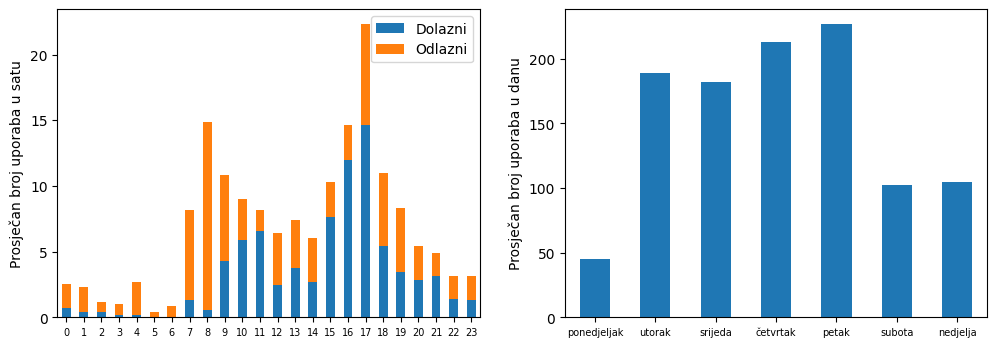

In [41]:
combined_plot_daily_weekly(hourly.loc[station],daily.loc[station])[0]

In [42]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Ukupno korištenja bicikala: ",
                               no_bins = 12)



In [43]:
CREATE_IMAGES = False

# Add a popup to each Circle
# temporarily, the same image for all stations

# set to false to speed up when working on notebook
if CREATE_IMAGES:
    for i in range(len(circles)):
        circ = circles[i]

        station_uid = locations_changes["uid"].iloc[i]

        circ.add_child(folium.Popup(stringify_plot(
            combined_plot_daily_weekly(hourly.loc[station_uid], daily.loc[station_uid])[0]
            )))

    _ = [circ.add_to(m) for circ in circles]

In [44]:
m